In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    
    return series[..., np.newaxis].astype(np.float32)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

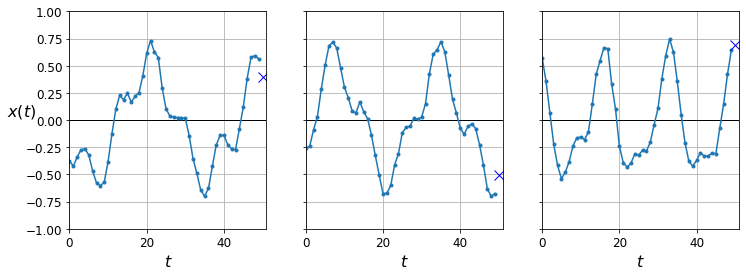

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
    
plt.show()

In [6]:
# before start using RNNs, it's a good idea to have a few baseline metrics
# native forecasting
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

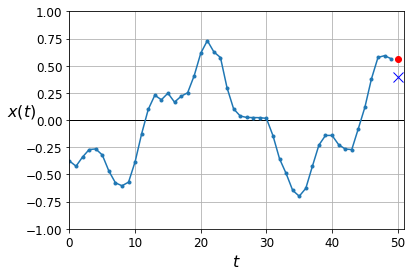

In [7]:
# slightly off
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 161us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/20
7000/7000 [==============================] - 0s 47us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
7000/7000 [==============================] - 0s 47us/sample - loss: 0.0205 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 0s 48us/sample - loss: 0.0133 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 0s 50us/sample - loss: 0.0104 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 0s 50us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 0s 60us/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 0s 48us/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
7000/7000 [==============================] - 0s 51us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 

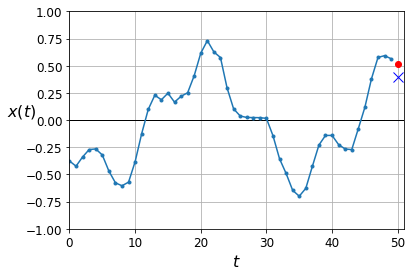

In [8]:
# linear regression is also off
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [9]:
# using a simple RNN

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 555us/sample - loss: 0.0972 - val_loss: 0.0491
Epoch 2/20
7000/7000 [==============================] - 3s 453us/sample - loss: 0.0372 - val_loss: 0.0298
Epoch 3/20
7000/7000 [==============================] - 3s 452us/sample - loss: 0.0255 - val_loss: 0.0220
Epoch 4/20
7000/7000 [==============================] - 3s 449us/sample - loss: 0.0200 - val_loss: 0.0178
Epoch 5/20
7000/7000 [==============================] - 3s 446us/sample - loss: 0.0167 - val_loss: 0.0152
Epoch 6/20
7000/7000 [==============================] - 3s 437us/sample - loss: 0.0147 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 3s 438us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 3s 435us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 3s 435us/sample - loss: 0.0119 - val_loss: 0.011

In [11]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 119us/sample - loss: 0.0109


0.010885455287992955

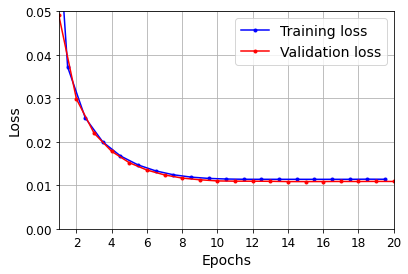

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

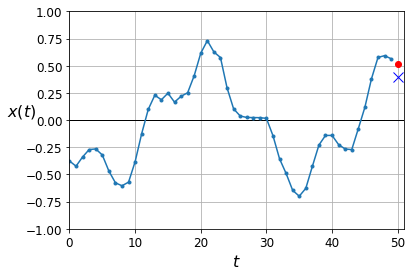

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
# it is better than naive but worse than linear

In [16]:
# deep RNNs

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

# you have to set return_sequences to True for all RNNs
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0433 - val_loss: 0.0073
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0066 - val_loss: 0.0052
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0051 - val_loss: 0.0043
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0045 - val_loss: 0.0044
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0040 - val_loss: 0.0038
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0038 - val_loss: 0.0042
Epoch 7/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0037 - val_loss: 0.0033
Epoch 8/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 9/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0034 - val_loss: 0.0038
Epoch 10/20
700

In [18]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 296us/sample - loss: 0.0029


0.002934106083586812

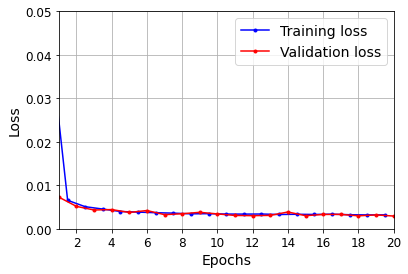

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

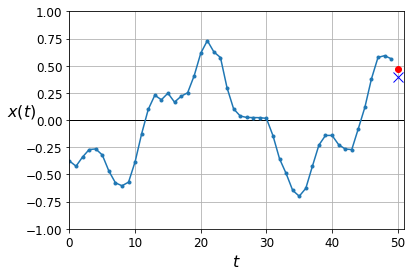

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [21]:
# change the last RNN layer to return only the last output because it trains faster

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0221 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 6s 894us/sample - loss: 0.0043 - val_loss: 0.0037
Epoch 3/20
7000/7000 [==============================] - 6s 914us/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 4/20
7000/7000 [==============================] - 6s 883us/sample - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 6s 867us/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 6s 850us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
7000/7000 [==============================] - 6s 858us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 6s 855us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 6s 872us/sample - loss: 0.0030 - val_loss: 0.0029


In [23]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 215us/sample - loss: 0.0026


0.0025768045093864204

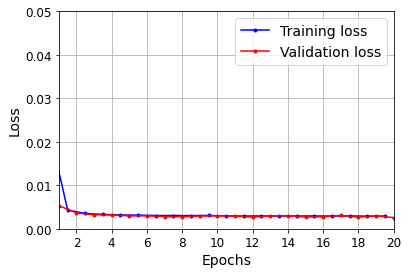

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

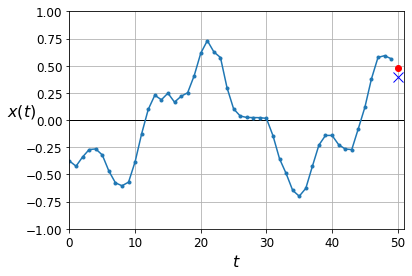

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [26]:
# forecasting several time steps ahead

In [27]:
# first option (errors will accumulate)
# this RNN model predicts one, feed it into the model again
# to predict the next value and repeat
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [28]:
Y_pred.shape

(1, 10, 1)

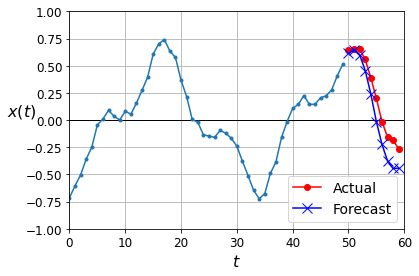

In [29]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [31]:
# use the above model to predict the next 10 values with 9 more time steps
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

# predict one by one
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

Y_pred.shape

(2000, 10)

In [32]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027277302

In [33]:
# comparing with baselines: naive and linear
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [34]:
# second option. predict 10 values at once by converting targets to be vectors
# containing 10 values
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0665 - val_loss: 0.0317
Epoch 2/20
7000/7000 [==============================] - 6s 880us/sample - loss: 0.0268 - val_loss: 0.0221
Epoch 3/20
7000/7000 [==============================] - 6s 837us/sample - loss: 0.0188 - val_loss: 0.0166
Epoch 4/20
7000/7000 [==============================] - 6s 840us/sample - loss: 0.0159 - val_loss: 0.0137
Epoch 5/20
7000/7000 [==============================] - 6s 846us/sample - loss: 0.0138 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 6s 856us/sample - loss: 0.0132 - val_loss: 0.0117
Epoch 7/20
7000/7000 [==============================] - 6s 841us/sample - loss: 0.0119 - val_loss: 0.0117
Epoch 8/20
7000/7000 [==============================] - 6s 835us/sample - loss: 0.0115 - val_loss: 0.0119
Epoch 9/20
7000/7000 [==============================] - 6s 835us/sample - loss: 0.0110 - val_loss: 0.0113


In [35]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

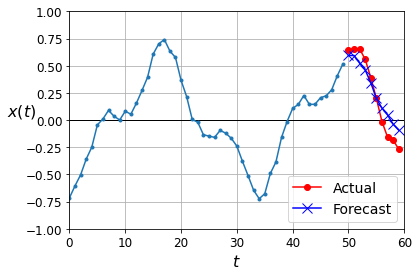

In [36]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [37]:
# you can do better by training the model to forecast the next 10 values at
# each time step
# we are going from sequence-to-vector to sequence-to-sequence RNN

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

# TimeDistributed applies the output Dense layer at every time step
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0498 - last_time_step_mse: 0.0388 - val_loss: 0.0416 - val_last_time_step_mse: 0.0321
Epoch 2/20
7000/7000 [==============================] - 6s 859us/sample - loss: 0.0384 - last_time_step_mse: 0.0276 - val_loss: 0.0325 - val_last_time_step_mse: 0.0212
Epoch 3/20
7000/7000 [==============================] - 6s 858us/sample - loss: 0.0318 - last_time_step_mse: 0.0207 - val_loss: 0.0309 - val_last_time_step_mse: 0.0210
Epoch 4/20
7000/7000 [==============================] - 6s 859us/sample - loss: 0.0291 - last_time_step_mse: 0.0178 - val_loss: 0.0274 - val_last_time_step_mse: 0.0160
Epoch 5/20
7000/7000 [==============================] - 6s 869us/sample - loss: 0.0272 - last_time_step_mse: 0.0154 - val_loss: 0.0258 - val_last_time_step_mse: 0.0137
Epoch 6/20
7000/7000 [==============================] - 6s 854us/sample - loss: 0.0246 - last_time_step_mse: 0.011

In [39]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

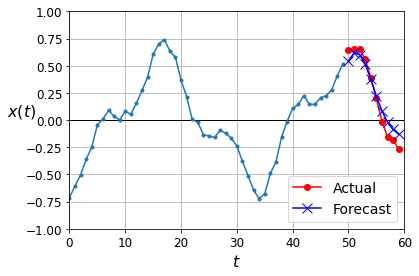

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [41]:
# Simple RNNs are good at time seires or handling sequnces but
# they don't perform as well on long time series or sequences

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.1936 - last_time_step_mse: 0.1913 - val_loss: 0.0901 - val_last_time_step_mse: 0.0863
Epoch 2/20
7000/7000 [==============================] - 7s 979us/sample - loss: 0.0531 - last_time_step_mse: 0.0441 - val_loss: 0.0559 - val_last_time_step_mse: 0.0469
Epoch 3/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0354
Epoch 4/20
7000/7000 [==============================] - 7s 951us/sample - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0423 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 7s 944us/sample - loss: 0.0414 - last_time_step_mse: 0.0310 - val_loss: 0.0402 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 7s 960us/sample - loss: 0.0390 - last_time_step_mse: 0.0283 

In [43]:
# to solve vanishing/exploding gradient problem
# you can use Layer Normalization
# instead of normalizaing across the batch dimension, it normalizes
# across features dimension
# similarly you can create a custom cell to apply dropout between each time step

from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]
    
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.1582 - last_time_step_mse: 0.1527 - val_loss: 0.0722 - val_last_time_step_mse: 0.0670
Epoch 2/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0634 - last_time_step_mse: 0.0568 - val_loss: 0.0568 - val_last_time_step_mse: 0.0501
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0541 - last_time_step_mse: 0.0469 - val_loss: 0.0507 - val_last_time_step_mse: 0.0436
Epoch 4/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0496 - last_time_step_mse: 0.0423 - val_loss: 0.0475 - val_last_time_step_mse: 0.0405
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0451 - last_time_step_mse: 0.0370 - val_loss: 0.0413 - val_last_time_step_mse: 0.0312
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0393 - last_time_step_mse: 0.0288 - 

In [44]:
# custom RNN class
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs
        
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.2184 - last_time_step_mse: 0.2042 - val_loss: 0.0862 - val_last_time_step_mse: 0.0764
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0719 - last_time_step_mse: 0.0603 - val_loss: 0.0627 - val_last_time_step_mse: 0.0518
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0575 - last_time_step_mse: 0.0440 - val_loss: 0.0533 - val_last_time_step_mse: 0.0385
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0506 - last_time_step_mse: 0.0363 - val_loss: 0.0484 - val_last_time_step_mse: 0.0333
Epoch 5/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0461 - last_time_step_mse: 0.0319 - val_loss: 0.0443 - val_last_time_step_mse: 0.0294
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0429 - last_time_step_mse: 0.0289 - 

In [45]:
# tackling the short term memory problem
# at each time step, some information is loat
# LSTM solves this problem
# this one is old. GRU is simplier but work just as well as LSTM
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 575us/sample - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0372
Epoch 2/20
7000/7000 [==============================] - 1s 177us/sample - loss: 0.0480 - last_time_step_mse: 0.0281 - val_loss: 0.0423 - val_last_time_step_mse: 0.0211
Epoch 3/20
7000/7000 [==============================] - 1s 178us/sample - loss: 0.0390 - last_time_step_mse: 0.0182 - val_loss: 0.0371 - val_last_time_step_mse: 0.0164
Epoch 4/20
7000/7000 [==============================] - 1s 178us/sample - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0335 - val_last_time_step_mse: 0.0143
Epoch 5/20
7000/7000 [==============================] - 1s 177us/sample - loss: 0.0325 - last_time_step_mse: 0.0136 - val_loss: 0.0314 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 1s 177us/sample - loss: 0.0308 - last_time_step_mse: 0.0

In [46]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 85us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.02401665285229683, 0.008551411]

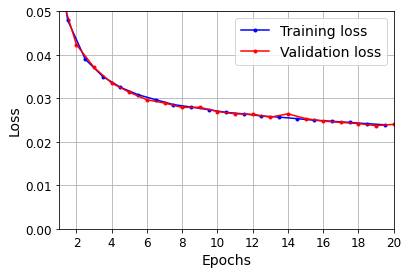

In [47]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [48]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

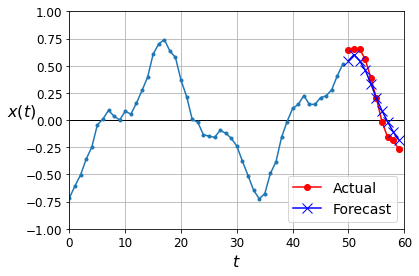

In [49]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [51]:
# GRU cell is simpler than LSTM but work just as well
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 543us/sample - loss: 0.0742 - last_time_step_mse: 0.0663 - val_loss: 0.0523 - val_last_time_step_mse: 0.0421
Epoch 2/20
7000/7000 [==============================] - 1s 172us/sample - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0327
Epoch 3/20
7000/7000 [==============================] - 1s 168us/sample - loss: 0.0418 - last_time_step_mse: 0.0305 - val_loss: 0.0391 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 1s 168us/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0343 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 1s 169us/sample - loss: 0.0327 - last_time_step_mse: 0.0179 - val_loss: 0.0313 - val_last_time_step_mse: 0.0158
Epoch 6/20
7000/7000 [==============================] - 1s 174us/sample - loss: 0.0308 - last_time_step_mse: 0.0

In [52]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 0s 77us/sample - loss: 0.0241 - last_time_step_mse: 0.0103


[0.02407100549340248, 0.010298314]

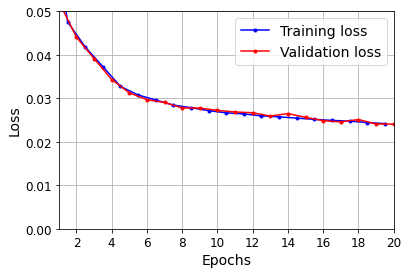

In [53]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [54]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

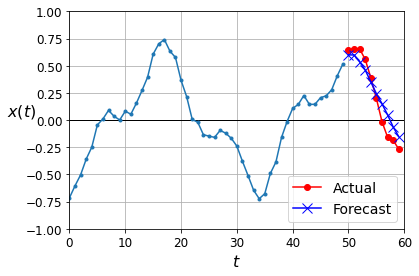

In [55]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [58]:
# LSTM and GRU are good but they still have limited short-term memory
# they have difficulty with 100 time steps or more
# so to solve this, you can use 1D convolutional layers

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 564us/sample - loss: 0.0683 - last_time_step_mse: 0.0605 - val_loss: 0.0482 - val_last_time_step_mse: 0.0405
Epoch 2/20
7000/7000 [==============================] - 1s 144us/sample - loss: 0.0416 - last_time_step_mse: 0.0342 - val_loss: 0.0368 - val_last_time_step_mse: 0.0283
Epoch 3/20
7000/7000 [==============================] - 1s 143us/sample - loss: 0.0334 - last_time_step_mse: 0.0251 - val_loss: 0.0307 - val_last_time_step_mse: 0.0220
Epoch 4/20
7000/7000 [==============================] - 1s 144us/sample - loss: 0.0273 - last_time_step_mse: 0.0172 - val_loss: 0.0251 - val_last_time_step_mse: 0.0141
Epoch 5/20
7000/7000 [==============================] - 1s 147us/sample - loss: 0.0243 - last_time_step_mse: 0.0134 - val_loss: 0.0238 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 1s 145us/sample - loss: 0.0230 - last_time_step_mse: 0.0

In [60]:
# wavenet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 377us/sample - loss: 0.0684 - last_time_step_mse: 0.0550 - val_loss: 0.0385 - val_last_time_step_mse: 0.0249
Epoch 2/20
7000/7000 [==============================] - 1s 114us/sample - loss: 0.0341 - last_time_step_mse: 0.0215 - val_loss: 0.0306 - val_last_time_step_mse: 0.0183
Epoch 3/20
7000/7000 [==============================] - 1s 115us/sample - loss: 0.0292 - last_time_step_mse: 0.0173 - val_loss: 0.0274 - val_last_time_step_mse: 0.0156
Epoch 4/20
7000/7000 [==============================] - 1s 116us/sample - loss: 0.0270 - last_time_step_mse: 0.0153 - val_loss: 0.0264 - val_last_time_step_mse: 0.0148
Epoch 5/20
7000/7000 [==============================] - 1s 114us/sample - loss: 0.0255 - last_time_step_mse: 0.0138 - val_loss: 0.0248 - val_last_time_step_mse: 0.0131
Epoch 6/20
7000/7000 [==============================] - 1s 117us/sample - loss: 0.0245 - last_time_step_mse: 0.0

In [62]:
# sketchRNN dataset

In [63]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 24s 0us/step


In [64]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [65]:
train_files

['C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\training.tfrecord-00009-of-00010']

In [66]:
eval_files

['C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\Jay\\.keras\\datasets\\quickdraw\\eval.tfrecord-00009-of-00010']

In [67]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [68]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [69]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [70]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [71]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [72]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [73]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.08627451  0.11764706  0.        ]
  [-0.01176471  0.16806725  0.        ]
  [ 0.02352941  0.07563025  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.04705882 -0.06696428  0.        ]
  [-0.09019607 -0.07142857  0.        ]
  [-0.0862745  -0.04464286  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [ 0.00784314  0.11320752  0.        ]
  ...
  [ 0.11764708  0.01886791  0.        ]
  [-0.03529412  0.12264156  0.        ]
  [-0.19215688  0.33962262  1.        ]]

 ...

 [[-0.21276593 -0.01960784  0.        ]
  [-0.31382978  0.00784314  0.        ]
  [-0.37234044  0.13725491  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

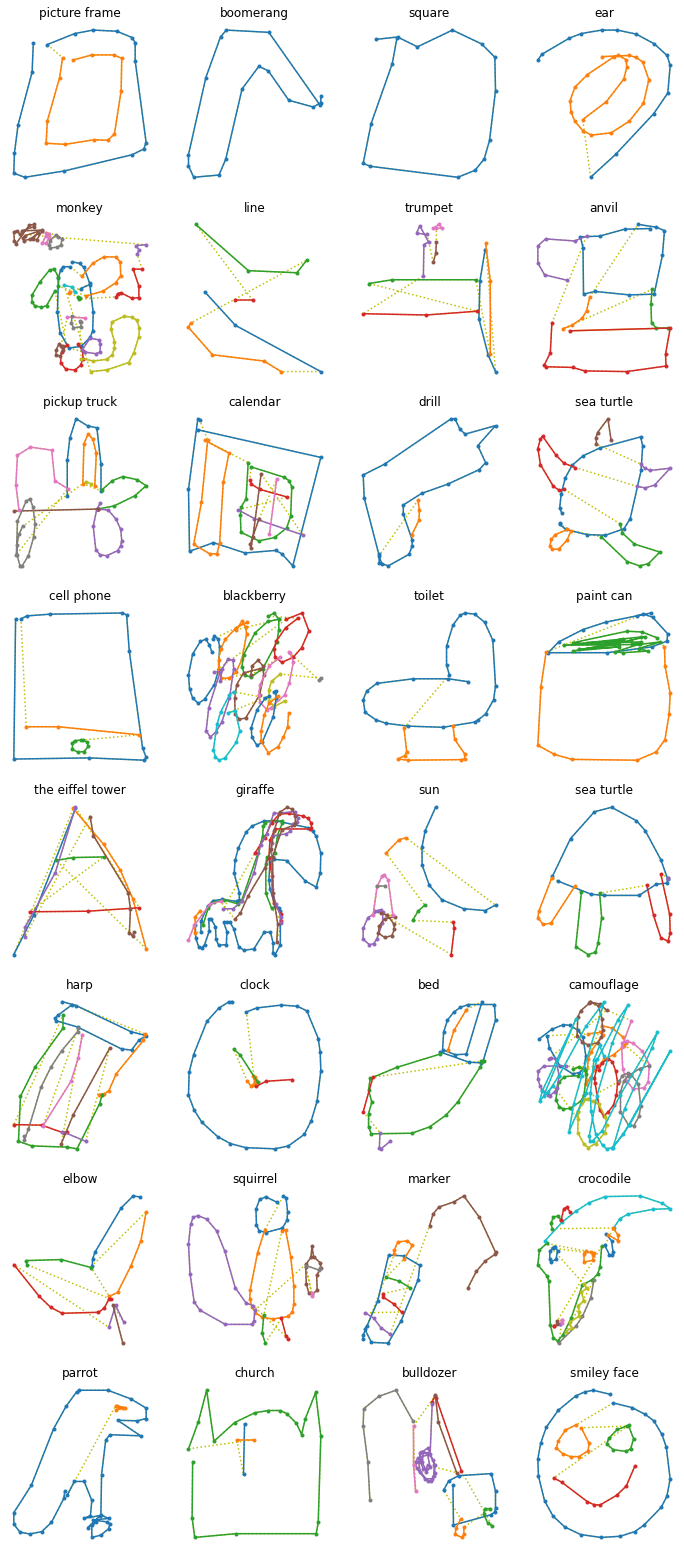

In [74]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

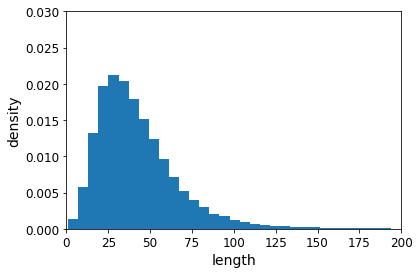

In [75]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [76]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [77]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2


 100191/Unknown - 2527s 25ms/step - loss: 3.9066 - accuracy: 0.2007 - sparse_top_k_categorical_accuracy: 0.4123- 1223s 18ms/step - loss: 4.3814 - accuracy: 0.1330 - sparse_top_k_categorica - 1223s 18ms/step - loss: 4.3811 - accuracy: 0.1330 - sparse_top_k_catego - 1224s 18ms/step - loss: 4.3807 - accuracy: 0.1331 - sparse_t - 1226s 18m - 1229s 18ms/step - loss: 4.3786 - accuracy: 0.1334 - sparse_top_k_c - 1230s 18ms/step - loss: 4.3781 - accuracy: 0.1334 - sparse_top_k_categori - 1231s 18ms/step - loss: 4.3777 - accuracy: 0.1335 - sparse_top_k_ - 1232s 18ms - 1329s 19ms/step - loss: 4.3352 - 1332s 19ms/ - 1335s 19ms/step - loss: 4.3328 - accuracy: 0.1396 - sparse_t - 1336s 19ms/step - loss: 4.3322 - accuracy: 0.1397 - sparse_top_k_categorical_accuracy:  - 1336s 19ms/step - loss: 4.3321 - accuracy: 0.1397 - sparse_top_k_categorica - 1341s 19ms/step - los - 1363s 19ms/step - loss: 4.3208 - accuracy: 0.1412 - sparse_top_k_categorical_accurac - 1363s 19ms/step - loss: 4.3207 - accuracy: 0.

107813/107813 [==============================] - 2879s 27ms/step - loss: 3.8187 - accuracy: 0.2138 - sparse_top_k_categorical_accuracy: 0.4312 - val_loss: 2.7260 - val_accuracy: 0.3737 - val_sparse_top_k_categorical_accuracy: 0.6664ms/step - loss: 3.8802 - accuracy: 0.2047 - sparse_top_k_cat - 2619s 26ms/step - loss: 3.8799 - accurac - 2621s 26ms/step - loss: 3.8792 - accuracy: 0.2048 - sparse_top_k_categorical_accuracy: - 2621s 26ms/step - loss: 3.8792 - accuracy: 0.2048 - sparse_ - 2622s 26ms/step - loss: 3.8788 - accuracy: 0.2049 - sparse_top_k_categorical_accuracy: 0.418 - 2622s 26ms/step - loss: 3.8788 - accuracy: 0.2049 - sparse_top_k_categorical_ - 2631s 26ms/ - 2634s 26ms/step - loss: 3.8753 - accuracy: 0.2054 - sparse_top_k_categorical_accurac - 2635s 26ms/step - loss: 3.8752 - accuracy: 0. - 2640s  - 2644s 26ms/step - loss: 3.8725 - accuracy: 0.2058 - sparse_top_k_categoric - 2645s 26ms/step - loss: 3.8723 - accuracy: 0.2058 - sparse_top_k_c - 2646s 26ms/step - loss: 3.8720 -

In [78]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [79]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.68319345

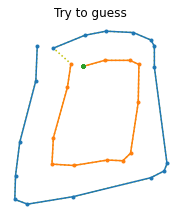

Top-5 predictions:
  1. paper clip 31.869%
  2. cell phone 10.867%
  3. microwave 7.254%
  4. computer 6.248%
  5. door 4.887%
Answer: picture frame


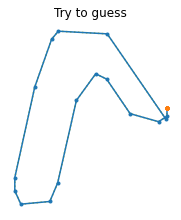

Top-5 predictions:
  1. rifle 45.898%
  2. garden hose 7.278%
  3. boomerang 4.667%
  4. trumpet 2.665%
  5. moustache 2.215%
Answer: boomerang


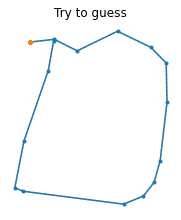

Top-5 predictions:
  1. hexagon 47.145%
  2. octagon 22.280%
  3. bench 3.200%
  4. square 3.139%
  5. keyboard 2.903%
Answer: square


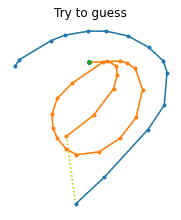

Top-5 predictions:
  1. boomerang 30.497%
  2. ear 18.729%
  3. squiggle 12.390%
  4. garden hose 7.994%
  5. moon 4.235%
Answer: ear


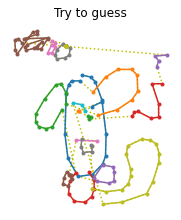

Top-5 predictions:
  1. monkey 13.691%
  2. pear 7.782%
  3. blueberry 6.003%
  4. snowman 5.969%
  5. telephone 4.109%
Answer: monkey


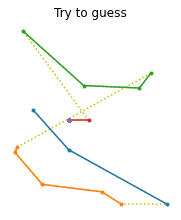

Top-5 predictions:
  1. fork 12.208%
  2. floor lamp 9.901%
  3. beach 9.574%
  4. ocean 8.663%
  5. see saw 6.685%
Answer: line


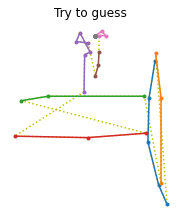

Top-5 predictions:
  1. snowflake 49.211%
  2. rake 5.343%
  3. see saw 5.131%
  4. sword 4.808%
  5. diving board 4.211%
Answer: trumpet


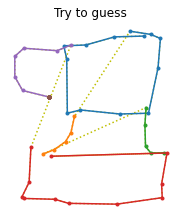

Top-5 predictions:
  1. yoga 13.924%
  2. screwdriver 13.263%
  3. lantern 11.507%
  4. syringe 9.141%
  5. shovel 5.990%
Answer: anvil


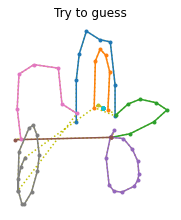

Top-5 predictions:
  1. eyeglasses 11.971%
  2. ant 11.458%
  3. motorbike 10.929%
  4. bicycle 8.840%
  5. headphones 7.518%
Answer: pickup truck


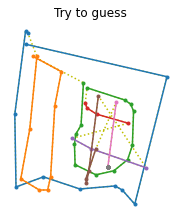

Top-5 predictions:
  1. ant 19.254%
  2. yoga 15.787%
  3. megaphone 15.595%
  4. stereo 7.451%
  5. flashlight 5.923%
Answer: calendar


In [80]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [81]:
model.save("my_sketchrnn")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_sketchrnn\assets
